# Sprint 深層学習スクラッチ　ディープニューラルネットワーク

In [1]:
import numpy as np
import random
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # testとtrain分割
from sklearn.metrics import accuracy_score
import math

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
print("X_train{}".format(X_train.shape)) # (60000, 28, 28)
print("X_test{}".format(X_test.shape)) # (10000, 28, 28)
print("y_train{}".format(y_train.shape))# (60000,)
print("y_test{}".format(y_test.shape))#(10000, )
print(X_train[0].dtype) # uint8

X_train(60000, 28, 28)
X_test(10000, 28, 28)
y_train(60000,)
y_test(10000,)
uint8


In [6]:
# (1, 28, 28)の各画像を、(1, 784)に変換
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [7]:
## 前処理
#画像は0から255のuint8型で表されますが、
#機械学習をする上では0から1のfloat型で扱うことになります。以下のコードで変換可能です。
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255 # 全て２５５で割っている
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [8]:
# yをone-hot表現に変換

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [9]:
# test,valデータに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000,)
(12000,)


In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 【問題1】全結合層のクラス化

In [11]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    #(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        #最適化メソッド
        self.optimizer = optimizer
        #initializerのメソッドを使い、self.Wとself.Bを初期化する
#         self.n_nodes1 = n_nodes1
#         self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2)
        #self.gradientLZ = None
        self.gradientLW = None
        self.gradientLB = None
        self.HW = 0
        self.HB = 0
        
    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        

        self.Z = Z
        #print("self.Z\n{}".format(self.Z))
        A = self.Z@self.W + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.gradientLB = np.sum(dA, axis=0) #optimizer(SGD)に渡して下で更新できるように勾配Bにself.つけている
        self.gradientLW = self.Z.T@dA # optimizer(SGD)に渡して下で更新できるように勾配Wにself.つけている
        dZ = dA@self.W.T # optimizer(SGD)に渡して下で更新できるようにWにself.つけている
    
        #WとBを更新（外で作ったインスタンス（FC1など）が、self.、optimizerのself.も保持している）FC１などのWとBを更新したい
        self.optimizer.update(self)
        
        return dZ

### 【問題2】初期化方法のクラス化

In [12]:
class SimpleInitializer():
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma=0.01):
        self.σ = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        
        # W(重み)の初期値を用意
        W = self.σ * np.random.randn(n_nodes1, n_nodes2)
        self.W = W
        return self.W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        # B(バイアス)の形を用意
        B = self.σ * np.random.randn(n_nodes2)
        self.B = B
        return self.B

### 【問題3】最適化手法のクラス化

In [13]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self,lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        #Wの更新式
        layer.W = layer.W - layer.gradientLW*self.lr
        
        # Bの更新式
        layer.B = layer.B - layer.gradientLB*self.lr
        
        #return layer #参照渡しのため、なくてもよい

### 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [14]:
# activation
# 活性化関数（シグモイド関数）
class Sigmoid:
    def __init__(self):
        self.Z = None
    def forward(self, A):
        Z = 1/(1+np.exp(-A))
        self.Z = Z
        return self.Z
    def backward(self, A):
        gradientLA = self.gradientLZ@(1.0 - self.Z)*self.Z
        return gradientLA

#活性化関数（ハイパボリックタンジェント関数）
class Tanh: #フォワードの時の数値を保存しておく
#     def __init__(self):
#         self.gradientLZ = None
    def forward(self, A):
        return np.tanh(A)

    def backward(self, dZ, A):
        gradientLA = dZ*(1 - np.tanh(A)**2) # ⭐️(20,200)(20,200)
        return gradientLA        

#ソフトマックス関数で確率ベクトルを求める関数(バッチサイズ分:２０個)
class Softmax:
    def forward(self, A):
        if A.ndim == 2:
            A = A.T
            A = A - np.max(A, axis=0)
            Z = np.exp(A) / np.sum(np.exp(A), axis=0)
            self.Z = Z
            return self.Z.T
        c = A - np.max(A)
        self.Z = np.exp(c) / np.sum(np.exp(c))
        return self.Z
            
    def backward(self, y):
        dA = self.Z.T - y
        return dA

### 【問題5】ReLUクラスの作成

In [15]:
#活性化関数
class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self, X):
        self.mask = (X <= 0)#0以下の値のインデックスをとる
        z = X.copy()
        self.X = X
        z[self.mask] = 0
        return np.maximum(0, self.X)

    def backward(self, dZ, A):
        dZ[self.mask] = 0 
        dout = dZ
        return dout

### 【問題6】重みの初期値
シグモイド関数やハイパボリックタンジェント関数のときはXavierInitializerクラスがよい。 ReLUのときはHeInitializerクラスがよい。

In [16]:
# XavierInitializerクラス（初期値）
class Xavier():
    """
    Xavierによる初期化
    """
    def __init__(self, n_nodes1):
        self.σ = 1/math.sqrt(n_nodes1)
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        
        # W(重み)の初期値を用意
        W = self.σ * np.random.randn(n_nodes1, n_nodes2)
        self.W = W
        return self.W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        # B(バイアス)の形を用意
        B = self.σ * np.random.randn(n_nodes2)
        self.B = B
        return self.B

In [17]:
# HeInitializerクラス（初期値）
class He():
    """
    Heによる初期化
    """
    def __init__(self, n_nodes1):
        self.σ = math.sqrt(2/n_nodes1)
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
​
        Returns
        ----------
        W :
        """
        
        # W(重み)の初期値を用意
        W = self.σ * np.random.randn(n_nodes1, n_nodes2)
        self.W = W
        return self.W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
​
        Returns
        ----------
        B :
        """
        # B(バイアス)の形を用意
        B = self.σ * np.random.randn(n_nodes2)
        self.B = B
        return self.B

### 【問題7】最適化手法
学習率は学習過程で変化させていく方法


In [18]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self,lr):
        self.lr = lr
        self.HW = 0
        self.HB = 0
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """

        layer.HW = layer.HW + np.mean(layer.gradientLW**2)
        layer.HB = layer.HB + np.mean(layer.gradientLB**2)
        #print("HW:",layer.HW.shape)
        #print("W:",layer.W.shape)
        #print("LW:",layer.gradientLW.shape)
        
        #Wの更新式
        layer.W = layer.W - self.lr*layer.gradientLW/math.sqrt(layer.HW)
        
        # Bの更新式
        layer.B = layer.B - self.lr*layer.gradientLB/math.sqrt(layer.HB)
        
        return layer #参照渡しのため、なくてもよい

### 【問題8】クラスの完成

In [20]:
class ScratchDeepNeuralNetrowkClassifier():
    def __init__(self, lr = 0.01, n_nodes1 = 400,  n_nodes2 = 200, n_output = 10, sigma = 0.01, n_epoc=5, optimizer=SGD):
        #初期化に使う関数
        #self.Initializer = Initializer()
        # 活性化関数
        #self.activation = activation
        
        self.lr = lr #学習率
        self.n_output = n_output # 出力層のノード数
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.sigma = sigma
        #学習率の設定
        self.optimizer = optimizer(self.lr)
        
        #損失を記録
        self.loss_list = []
        self.val_loss_list = []
        self.n_epoc = n_epoc
        

    #交差エントロピー関数(仮に作った予測値と正解の差を出す)  
    def _cross_entropy(self, y_train, Z3):
        L = - np.mean(np.sum(y_train*np.log(Z3), axis=1)) #　問７で使う　fit,predictでは使わない
        return L
               
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        self.n_features = X_train.shape[1]
        
        #初期化、学習率の関数をインスタンス化
        #initializer = He(self.n_nodes1) #初期化の関数を変えるときはここを書き換える
        #optimizer = SGD(self.lr)#学習率を層ごとに変化させたい場合はAdaGrad(self.lr) に書き換える
        
        self.FC1 = FC(self.n_features, self.n_nodes1, Xavier(self.n_features), self.optimizer)
        self.activation1 = ReLU()#別の活性化関数を使いたい場合はここを書き換える
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Xavier(self.n_nodes1), self.optimizer)
        self.activation2 = ReLU()#別の活性化関数を使いたい場合はここを書き換える
        self.FC3 = FC(self.n_nodes2, self.n_output, Xavier(self.n_nodes2), self.optimizer)
        self.activation3 = Softmax()
        
        # one-hot-encode
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        
        # ミニバッチ２０枚を取得
        get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=20)
        
        self.fit_Z3 = np.empty((0, self.n_output))#空の１行目作る

        
        #epoch
        for _ in range(self.n_epoc):
            for mini_X_train, mini_y_train in get_mini_batch:
                #イテレーションごとのフォワード　ここの層を増やしても対応できるようにできればより良い（for文などで）
                A1 = self.FC1.forward(mini_X_train)
                #print(A1.shape)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                #print("Z2{}".format(Z2))
                Z3 = self.activation3.forward(A3)
                #print("Z3{}".format(np.argmax(Z3,axis=1)))

                #イテレーションごとのバックワード
                dA3 = self.activation3.backward(mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                #print("dA3{}".format(dA3[-1]))
                dZ2 = self.FC3.backward(dA3)
                #print("dZ2{}".format(dZ2[-1]))
                dA2 = self.activation2.backward(dZ2, A2)
                #print("dA2{}".format(dA2[-1]))
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1, A1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                #print(dZ0.shape)
                #self.fit_Z3 = np.append(self.fit_Z3, self.Z3, axis=0)

                train_loss = self._cross_entropy(mini_y_train, Z3)
                self.loss_list.append(train_loss)
                #print(self.loss_list[-1])
            
        
    
    def predict(self, X):
        
        A1 = self.FC1.forward(X)
        #print(A1.shape)
        Z1 = self.activation1.forward(A1)
        #print(Z1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        #print(Z3.shape)
        predict = np.argmax(Z3, axis=1) #axis 方向確認する
        
        #学習曲線をプロット
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(self.loss_list, label='train loss')
        #ax.plot(self.val_loss_list, label='val loss')

        ax.legend()
        ax.set_xlabel("epoc [num]")
        ax.set_ylabel("cross entorpy")

        plt.show()
        
        return predict


### 【問題9】学習と推定

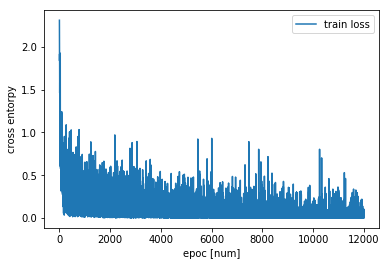

正解率 ：0.9738333333333333
予測
[5 2 3 3 6 3 0 1 2 5 9 3 0 9 8 9 5 9 8 5 1 8 4 6 3 7 1 5 6 4 8 1 7 0 6 9 3
 7 6 1 8 4 7 7 4 8 6 4 7 4 6 5 6 6 6 0 4 8 4 1 3 3 2 3 8 8 5 6 3 5 3 4 1 6
 9 7 9 2 3 7 2 2 1 4 2 6 1 0 8 8 1 2 2 9 8 2 8 8 1 8 5 9 1 0 7 4 2 6 7 0 6
 4 3 6 4 5 6 2 4 0 9 6 9 9 9 4 5 7 0 5 2 0 8 5 3 0 6 9 7 8 1 2 3 6 0 6 8 9
 2 1 9 6 5 9 6 6 7 9 8 6 9 7 9 7 9 8 6 3 3 3 4 4 3 8 2 4 0 5 9 8 8 3 0 0 0
 6 7 7 5 1 9 9 7 8 8 5 4 6 5 8 2 8 7 3 9 2 7 1 0 7 2 4 5 8 6 3 3 3 3 1 5 5
 4 4 0 0 3 9 9 1 9 5 8 9 3 4 2 3 2 5 8 9 9 4 6 2 2 8 8 5 1 9 0 2 9 9 0 1 1
 0 7 4 5 8 1 2 5 3 8 8 8 2 8 3 6 6 6 9 3 5 7 8 1 8 0 5 7 1 9 0 1 5 9 3 2 6
 1 4 0 4]
正解：
[5 2 3 3 6 3 0 1 2 5 9 3 0 9 8 9 5 9 8 5 1 8 4 6 3 7 1 5 6 4 8 1 7 0 6 9 3
 7 6 1 8 4 7 7 4 8 6 4 7 4 6 5 6 6 6 0 4 8 9 1 3 3 2 3 8 8 5 6 3 5 3 4 1 6
 9 7 9 2 3 7 8 2 1 4 2 6 1 0 8 1 1 2 2 9 8 2 8 8 1 8 5 5 1 0 7 4 2 6 7 0 6
 4 3 6 4 5 6 2 4 0 9 6 9 9 9 4 5 7 0 5 1 0 8 5 3 0 6 9 7 8 1 2 3 6 0 6 8 9
 2 1 9 6 5 9 6 6 7 9 8 6 9 2 9 7 9 8 6 3 3 3 4 4 3 8 2 4 0 

In [21]:
SDNN = ScratchDeepNeuralNetrowkClassifier(lr = 0.01, n_nodes1 = 400,  n_nodes2 = 200, n_output = 10, sigma = 0.01, n_epoc=5, optimizer=SGD)
SDNN.fit(X_train, y_train)
pred = SDNN.predict(X_val)
print("正解率 ：{}".format(accuracy_score(y_val, pred)))
print("予測\n{}".format(pred[:300]))
print("正解：\n{}".format(y_val[:300]))

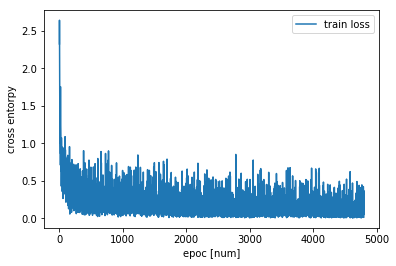

正解率 ：0.9566666666666667
予測
[5 2 3 5 6 3 0 1 2 5 9 3 0 9 8 1 5 9 8 5 1 8 4 6 3 7 1 5 6 4 8 1 7 0 6 9 3
 7 6 1 8 4 7 7 4 8 6 4 7 4 6 5 5 6 6 0 4 8 4 1 3 3 2 3 8 8 5 6 3 5 3 4 1 6
 9 7 9 2 3 7 8 2 1 4 2 6 1 0 8 1 1 2 2 9 8 2 8 8 1 8 5 7 1 0 7 4 2 6 7 0 6
 4 3 6 4 5 6 2 4 0 9 5 9 9 9 4 5 7 0 5 2 0 8 5 3 0 6 9 7 8 1 2 3 6 0 6 8 9
 2 1 4 6 5 5 6 6 7 4 8 6 9 2 9 7 9 8 6 3 3 3 4 4 3 8 2 4 0 5 9 8 1 3 0 0 0
 5 7 7 5 1 9 9 7 4 8 5 4 6 5 8 2 8 7 3 9 2 7 1 0 7 2 4 5 8 6 3 3 3 3 1 5 5
 4 4 0 0 3 9 9 1 9 5 8 9 3 4 2 3 2 5 8 9 9 4 6 2 2 8 8 5 1 9 0 2 9 9 0 1 1
 0 7 0 5 8 1 2 5 1 8 8 5 2 8 3 6 6 6 7 3 5 7 8 1 8 0 5 7 1 9 0 1 5 9 3 2 6
 1 4 0 4]
正解：
[5 2 3 3 6 3 0 1 2 5 9 3 0 9 8 9 5 9 8 5 1 8 4 6 3 7 1 5 6 4 8 1 7 0 6 9 3
 7 6 1 8 4 7 7 4 8 6 4 7 4 6 5 6 6 6 0 4 8 9 1 3 3 2 3 8 8 5 6 3 5 3 4 1 6
 9 7 9 2 3 7 8 2 1 4 2 6 1 0 8 1 1 2 2 9 8 2 8 8 1 8 5 5 1 0 7 4 2 6 7 0 6
 4 3 6 4 5 6 2 4 0 9 6 9 9 9 4 5 7 0 5 1 0 8 5 3 0 6 9 7 8 1 2 3 6 0 6 8 9
 2 1 9 6 5 9 6 6 7 9 8 6 9 2 9 7 9 8 6 3 3 3 4 4 3 8 2 4 0 

In [22]:
SDNN = ScratchDeepNeuralNetrowkClassifier(lr = 0.005, n_nodes1 = 400,  n_nodes2 = 200, n_output = 10, sigma = 0.01, n_epoc=2, optimizer=AdaGrad)
SDNN.fit(X_train, y_train)
pred = SDNN.predict(X_val)
print("正解率 ：{}".format(accuracy_score(y_val, pred)))
print("予測\n{}".format(pred[:300]))
print("正解：\n{}".format(y_val[:300]))

$
\hat{ y }
$